In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [2]:
df = pd.read_csv('train.csv')
df

,date,store,item,sales,f0,f1
0,01-01-2013,1,1,13.0,9.0,NaN
1,02-01-2013,1,1,11.0,NaN,NaN
2,03-01-2013,1,1,14.0,NaN,NaN
3,04-01-2013,1,1,13.0,NaN,NaN
4,05-01-2013,1,1,10.0,NaN,NaN
...,...,...,...,...,...,...
912995,27-12-2017,10,50,63.0,NaN,NaN
912996,28-12-2017,10,50,59.0,NaN,NaN
912997,29-12-2017,10,50,74.0,NaN,NaN
912998,30-12-2017,10,50,62.0,NaN,NaN


In [3]:
df.columns

Index(['date', 'store', 'item', 'sales', 'f0', 'f1'], dtype='object')

In [4]:
df.drop(['f0', 'f1'], axis=1, inplace=True)

In [5]:
df

,date,store,item,sales
0,01-01-2013,1,1,13.0
1,02-01-2013,1,1,11.0
2,03-01-2013,1,1,14.0
3,04-01-2013,1,1,13.0
4,05-01-2013,1,1,10.0
...,...,...,...,...
912995,27-12-2017,10,50,63.0
912996,28-12-2017,10,50,59.0
912997,29-12-2017,10,50,74.0
912998,30-12-2017,10,50,62.0


In [6]:
df.shape

(913000, 4)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    913000 non-null  object 
 1   store   913000 non-null  int64  
 2   item    913000 non-null  int64  
 3   sales   912943 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 27.9+ MB


In [8]:
df['date'] = df['date'].astype('datetime64[ns]')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   912943 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 27.9 MB


In [10]:
df.describe()

,date,store,item,sales
count,913000,913000.000000,913000.000000,912943.000000
mean,2015-07-02 12:00:00.000000512,5.500000,25.500000,52.251626
min,2013-01-01 00:00:00,1.000000,1.000000,0.000000
25%,2014-04-02 00:00:00,3.000000,13.000000,30.000000
50%,2015-07-02 12:00:00,5.500000,25.500000,47.000000
75%,2016-10-01 00:00:00,8.000000,38.000000,70.000000
max,2017-12-31 00:00:00,10.000000,50.000000,231.000000
std,NaN,2.872283,14.430878,28.801046


In [11]:
df.isnull().sum()

date      0
store     0
item      0
sales    57
dtype: int64

In [12]:
df = df.set_index('date')
df = df.interpolate()

In [13]:
df = df.reset_index(drop=False) 
df

,date,store,item,sales
0,2013-01-01,1,1,13.0
1,2013-02-01,1,1,11.0
2,2013-03-01,1,1,14.0
3,2013-04-01,1,1,13.0
4,2013-05-01,1,1,10.0
...,...,...,...,...
912995,2017-12-27,10,50,63.0
912996,2017-12-28,10,50,59.0
912997,2017-12-29,10,50,74.0
912998,2017-12-30,10,50,62.0


In [14]:
df.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [15]:
df.sort_values(by='date', ascending = True, inplace = True) 

In [16]:
df = df[df['store'] == 1]
df = df[df['item'] == 1]

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')


df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.weekday
df['weekday'] = np.where(df.weekday == 0, 7, df.weekday)

temp_df = df.set_index('date')
train_df = temp_df.loc[:'2017-09-30'].reset_index(drop=False)                         
test_df = temp_df.loc['2017-10-01':].reset_index(drop=False)

train_df.head()

,date,store,item,sales,year,month,day,weekday
0,2013-01-01,1,1,13.0,2013,1,1,1
1,2013-01-02,1,1,11.0,2013,1,2,2
2,2013-01-03,1,1,15.0,2013,1,3,3
3,2013-01-04,1,1,11.0,2013,1,4,4
4,2013-01-05,1,1,16.0,2013,1,5,5


In [17]:
test_df.head()

,date,store,item,sales,year,month,day,weekday
0,2017-10-01,1,1,11.0,2017,10,1,6
1,2017-10-02,1,1,16.0,2017,10,2,7
2,2017-10-03,1,1,18.0,2017,10,3,1
3,2017-10-04,1,1,19.0,2017,10,4,2
4,2017-10-05,1,1,17.0,2017,10,5,3


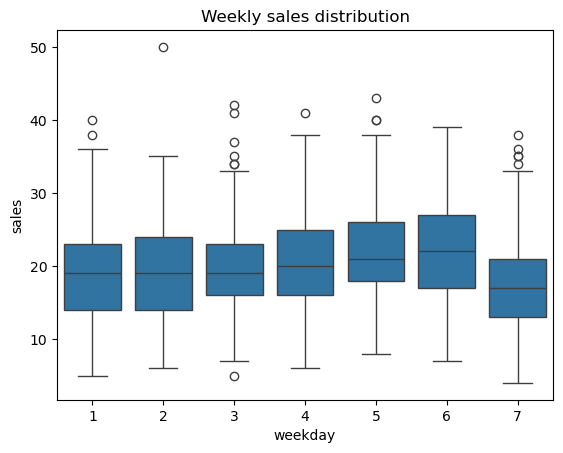

In [18]:
plot = sns.boxplot(x='weekday', y='sales', data=df)
plot.set(title='Weekly sales distribution')

plt.show()

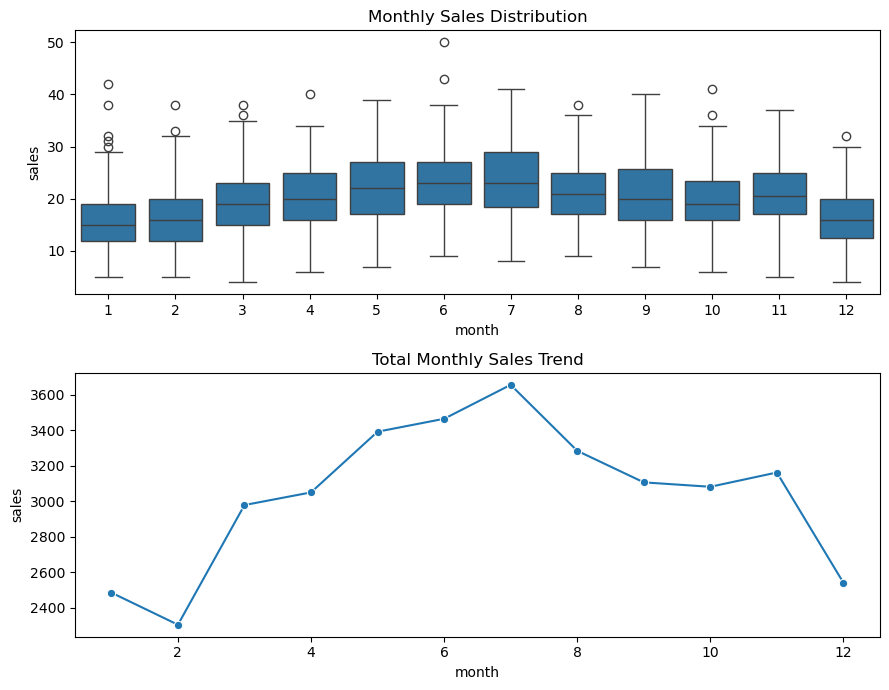

In [19]:
monthly_agg = df.groupby('month')['sales'].sum().reset_index()

fig, axs = plt.subplots(nrows=2, figsize=(9, 7))

sns.boxplot(x='month', y='sales', data=df, ax=axs[0])
axs[0].set_title('Monthly Sales Distribution')

sns.lineplot(x='month', y='sales', data=monthly_agg, marker='o', ax=axs[1])
axs[1].set_title('Total Monthly Sales Trend')

plt.tight_layout()
plt.show()


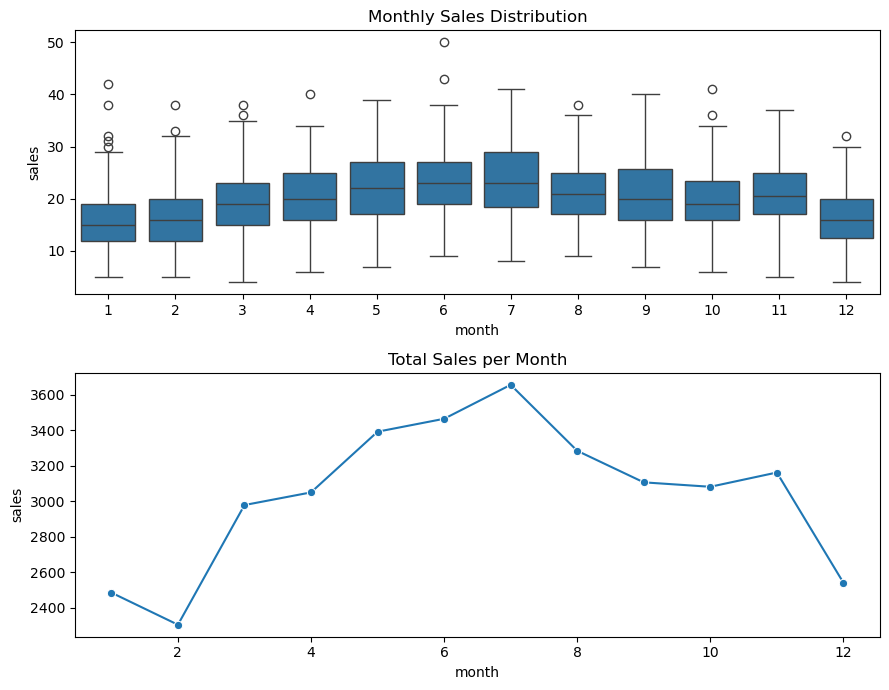

In [20]:
monthly_agg = df.groupby('month')['sales'].sum().reset_index()

fig, axs = plt.subplots(nrows=2, figsize=(9, 7))

sns.boxplot(x='month', y='sales', data=df, ax=axs[0])
axs[0].set_title('Monthly Sales Distribution')

sns.lineplot(x='month', y='sales', data=monthly_agg, marker='o', ax=axs[1])
axs[1].set_title('Total Sales per Month')

plt.tight_layout()
plt.show()


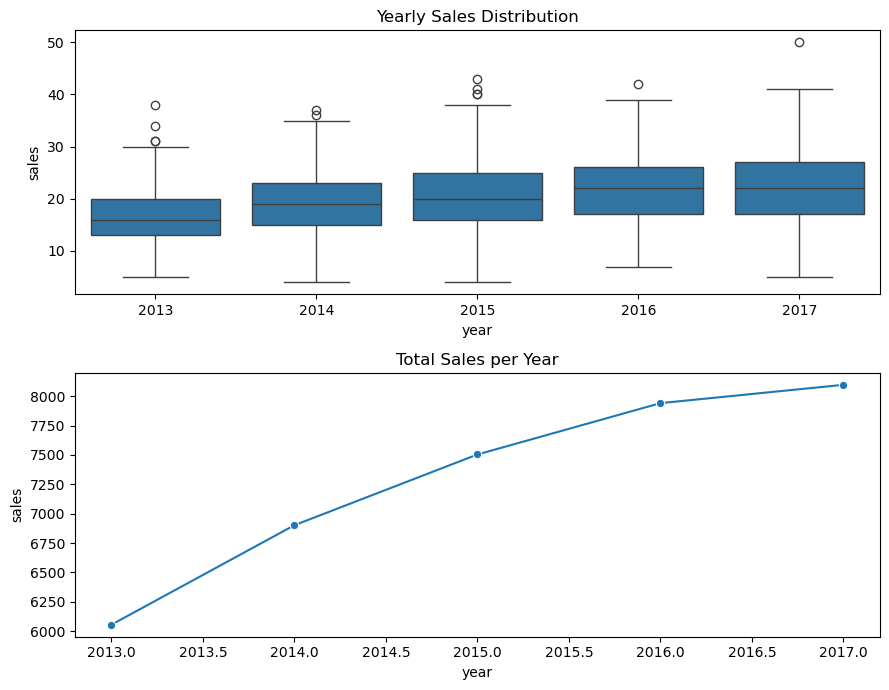

In [21]:
yearly_agg = df.groupby('year')['sales'].sum().reset_index()


fig, axs = plt.subplots(nrows=2, figsize=(9, 7))

sns.boxplot(x='year', y='sales', data=df, ax=axs[0])
axs[0].set_title('Yearly Sales Distribution')

sns.lineplot(x='year', y='sales', data=yearly_agg, marker='o', ax=axs[1])
axs[1].set_title('Total Sales per Year')

plt.tight_layout()
plt.show()


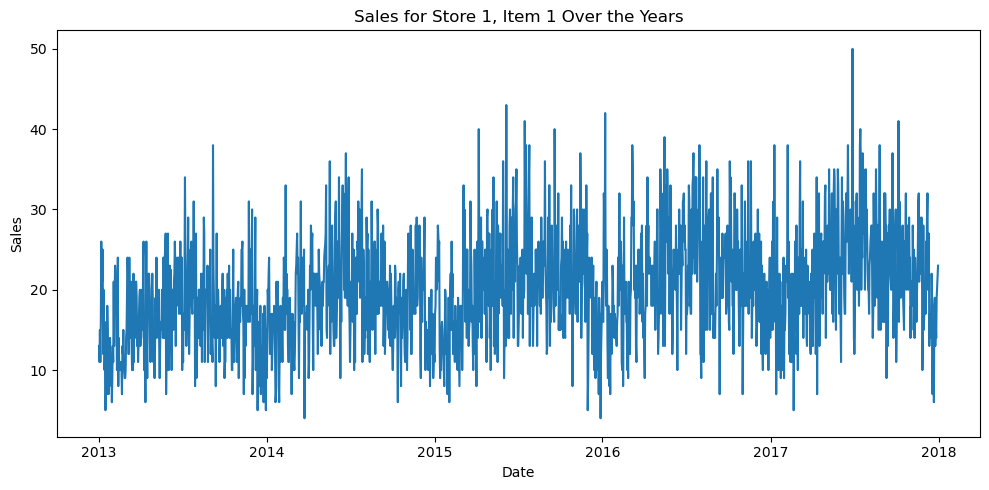

In [22]:
plt.figure(figsize=(10, 5))  
plot = sns.lineplot(x='date', y='sales', data=df)

plot.set(
    title='Sales for Store 1, Item 1 Over the Years',
    xlabel='Date',
    ylabel='Sales'
)

plt.tight_layout()
plt.show()


In [23]:
test_df['date'] = pd.to_datetime(test_df['date'])
train_df['date'] = pd.to_datetime(train_df['date'])


dates = test_df['date'] - pd.DateOffset(years=1)


seasonal_naive_sales = train_df[train_df['date'].isin(dates)]['sales'].reset_index(drop=True)


sn_pred_df = test_df.copy().drop('sales', axis=1)
sn_pred_df['seasonal_naive_sales'] = seasonal_naive_sales
sn_pred_df.head()


,date,store,item,year,month,day,weekday,seasonal_naive_sales
0,2017-10-01,1,1,2017,10,1,6,26.0
1,2017-10-02,1,1,2017,10,2,7,16.0
2,2017-10-03,1,1,2017,10,3,1,15.0
3,2017-10-04,1,1,2017,10,4,2,36.0
4,2017-10-05,1,1,2017,10,5,3,29.0


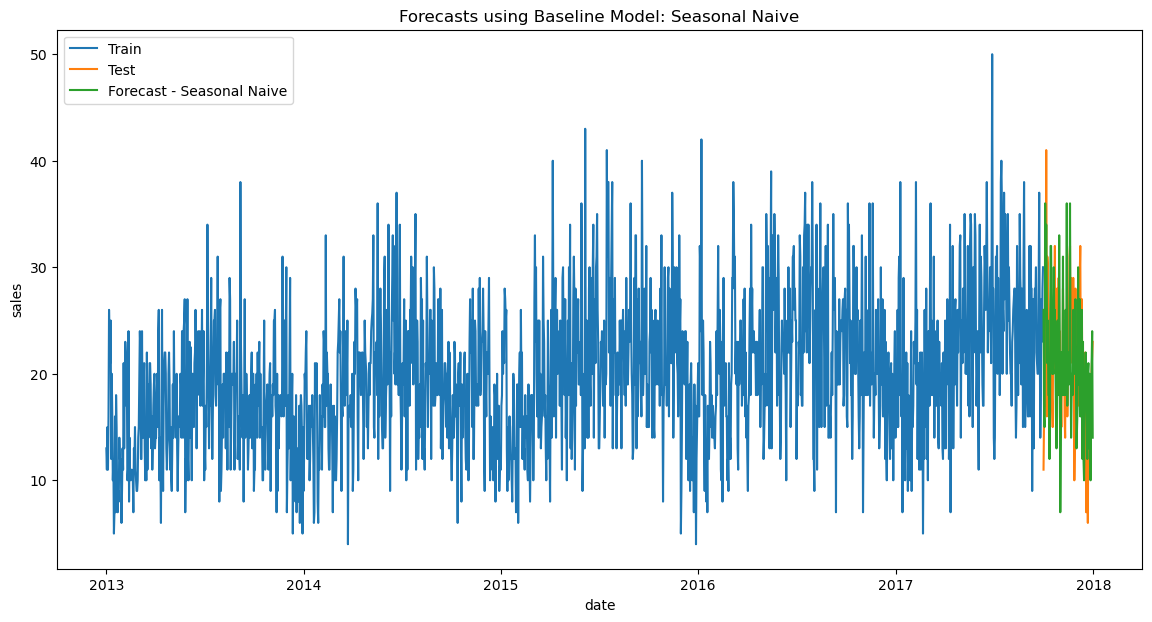

In [24]:
plt.figure(figsize=(14,7))
plt.plot(train_df['date'], train_df['sales'], label='Train')
plt.plot(test_df['date'], test_df['sales'], label='Test')
plt.plot(sn_pred_df['date'], sn_pred_df['seasonal_naive_sales'], label='Forecast - Seasonal Naive')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Baseline Model: Seasonal Naive')
plt.show()

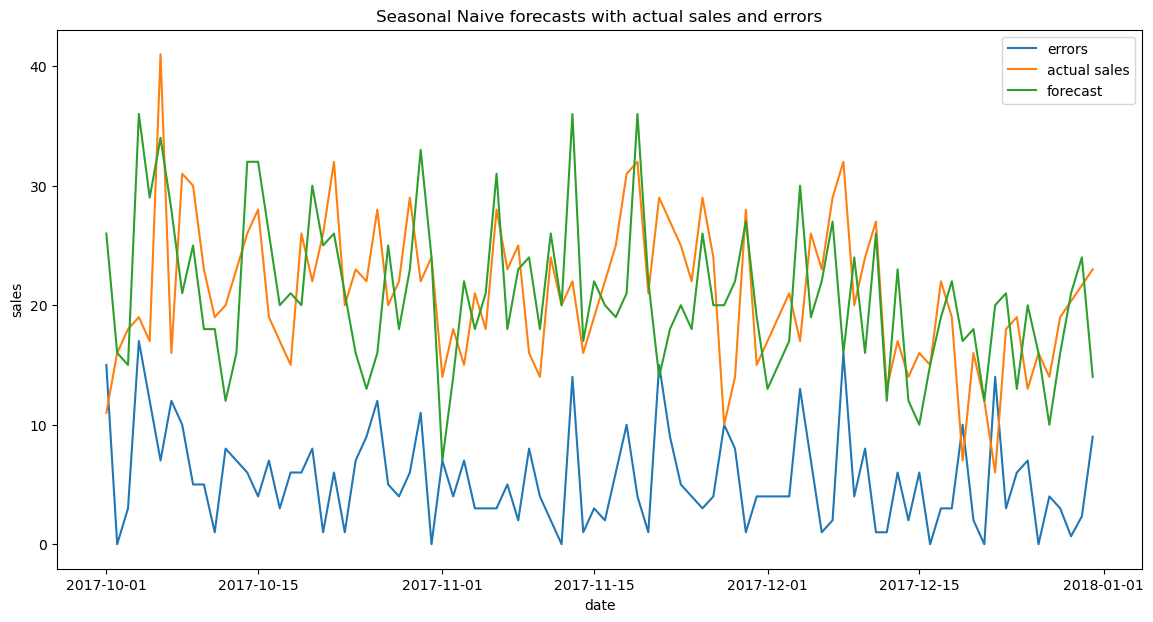

,total_sales,total_sn_pred_sales,overall_error,MAE,RMSE,MAPE
model,,,,,,
Seasonal Naive,1928.0,1914.0,14.0,5.456522,6.803842,26.037344


In [25]:
errors_df = pd.merge(test_df, sn_pred_df, on='date')
errors_df = errors_df[['date', 'sales', 'seasonal_naive_sales']]
errors_df = pd.merge(test_df, sn_pred_df, on='date')
errors_df = errors_df[['date', 'sales', 'seasonal_naive_sales']]
errors_df['errors'] = test_df['sales'] - sn_pred_df['seasonal_naive_sales']
errors_df.insert(0, 'model', 'Seasonal Naive') 

def mae(err):
    return np.mean(np.abs(err))

def rmse(err):
    return np.sqrt(np.mean(err ** 2))

def mape(err, sales=errors_df['sales']):
    return np.sum(np.abs(err))/np.sum(sales) * 100

result_df = errors_df.groupby('model').agg(total_sales=('sales', 'sum'),
                                           total_sn_pred_sales=('seasonal_naive_sales', 'sum'),
                                           overall_error=('errors', 'sum'),
                                           MAE=('errors', mae), 
                                           RMSE=('errors', rmse), 
                                           MAPE=('errors', mape))
    

plt.figure(figsize=(14,7))
plt.plot(errors_df['date'], np.abs(errors_df['errors']), label='errors')
plt.plot(errors_df['date'], errors_df['sales'], label='actual sales')
plt.plot(errors_df['date'], errors_df['seasonal_naive_sales'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Seasonal Naive forecasts with actual sales and errors')
plt.show()

result_df

In [26]:
ts_decomp_df = train_df.set_index('date') # set date as index
ts_decomp_df['sales'] = ts_decomp_df['sales'].astype(float)
ts_decomp_df.head()

,store,item,sales,year,month,day,weekday
date,,,,,,,
2013-01-01,1,1,13.0,2013,1,1,1
2013-01-02,1,1,11.0,2013,1,2,2
2013-01-03,1,1,15.0,2013,1,3,3
2013-01-04,1,1,11.0,2013,1,4,4
2013-01-05,1,1,16.0,2013,1,5,5


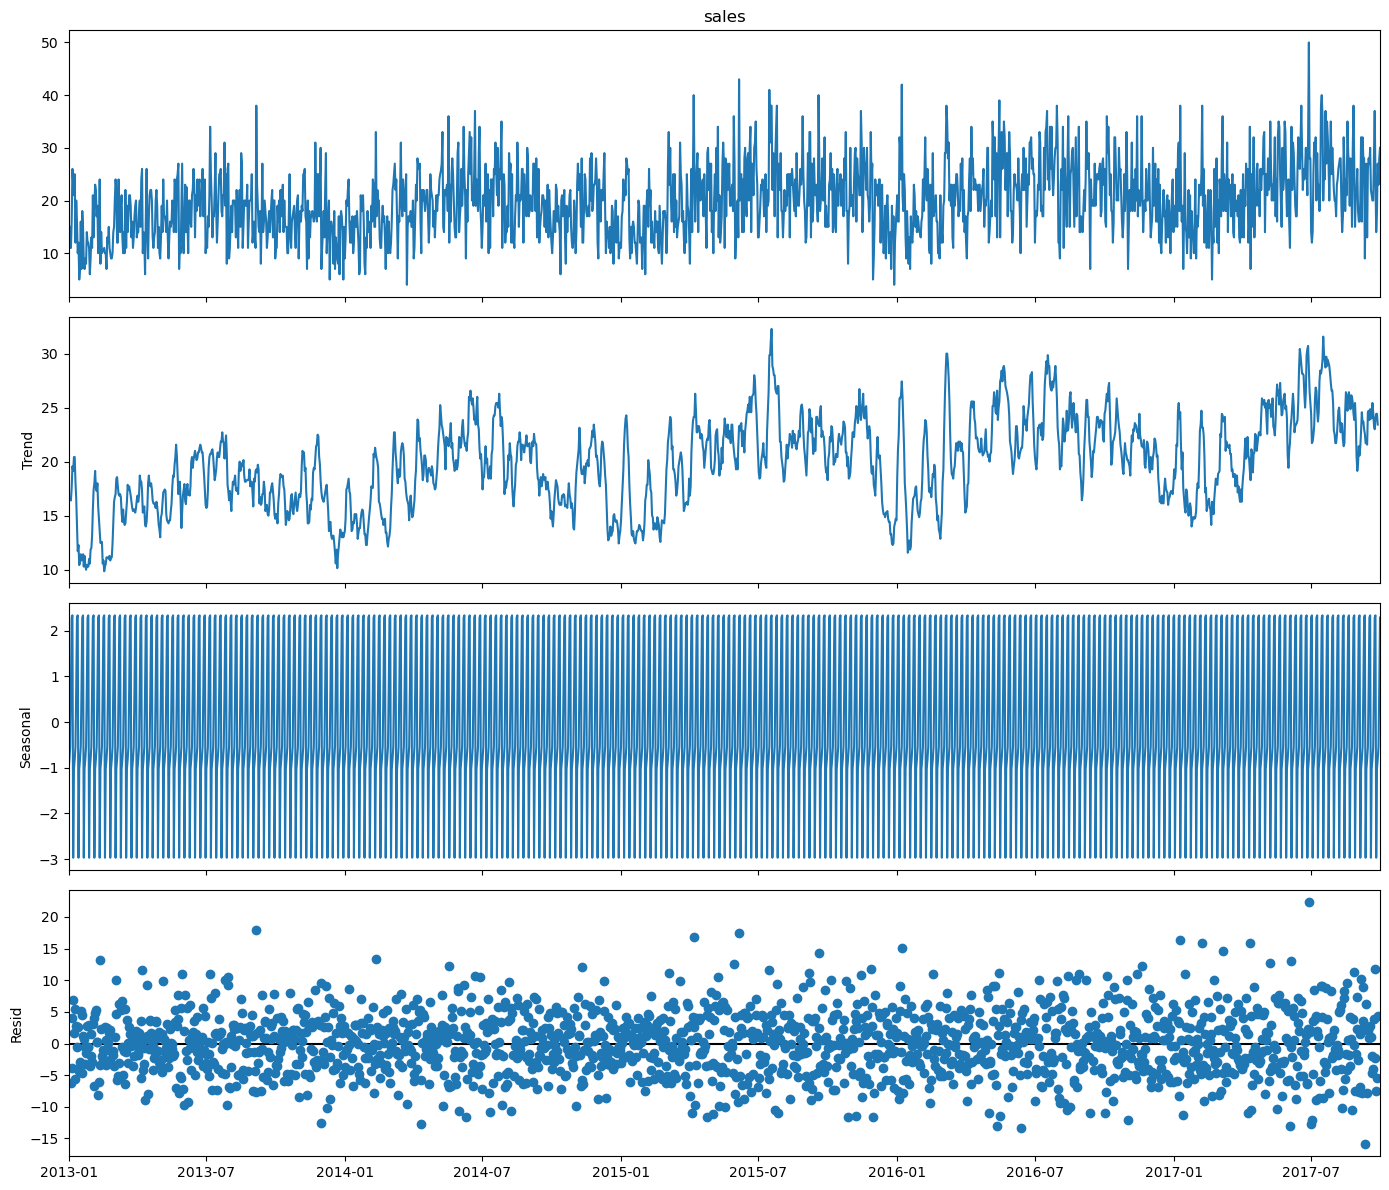

In [27]:
ts_decomp_df = ts_decomp_df.asfreq('D')

from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(ts_decomp_df['sales'], model='additive')


fig = result.plot()
fig.set_size_inches(14, 12)
plt.tight_layout()
plt.show()


In [28]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])

hw_train_df = train_df[['date', 'sales']].set_index('date').asfreq('D')
hw_test_df = test_df[['date', 'sales']].set_index('date').asfreq('D')

hw_model_1 = ExponentialSmoothing(hw_train_df, trend='add', seasonal='add', seasonal_periods=12)
hw_fit_1 = hw_model_1.fit(remove_bias=False)
pred_fit_1 = pd.Series(
    hw_fit_1.predict(start=hw_test_df.index[0], end=hw_test_df.index[-1]),
    name='pred_sales'
).reset_index()

hw_model_2 = ExponentialSmoothing(hw_train_df, trend='add', seasonal='add', seasonal_periods=12, damped=True)
hw_fit_2 = hw_model_2.fit(remove_bias=False)
pred_fit_2 = pd.Series(
    hw_fit_2.predict(start=hw_test_df.index[0], end=hw_test_df.index[-1]),
    name='pred_sales'
).reset_index()

print('Forecasts made, ready for evaluation')


Forecasts made, ready for evaluation


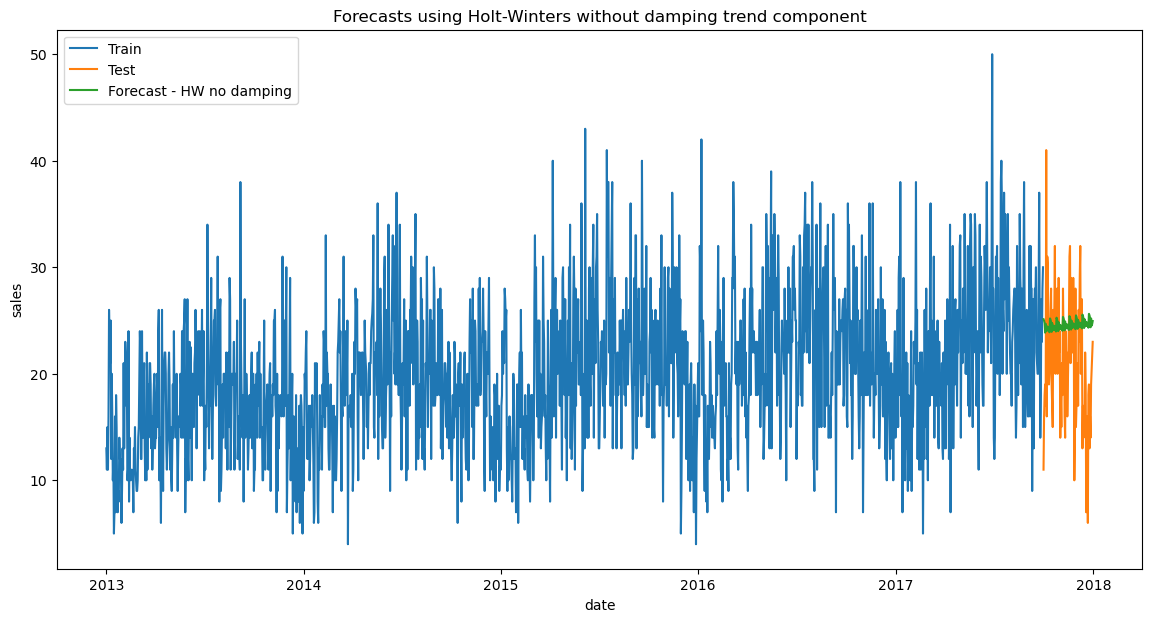

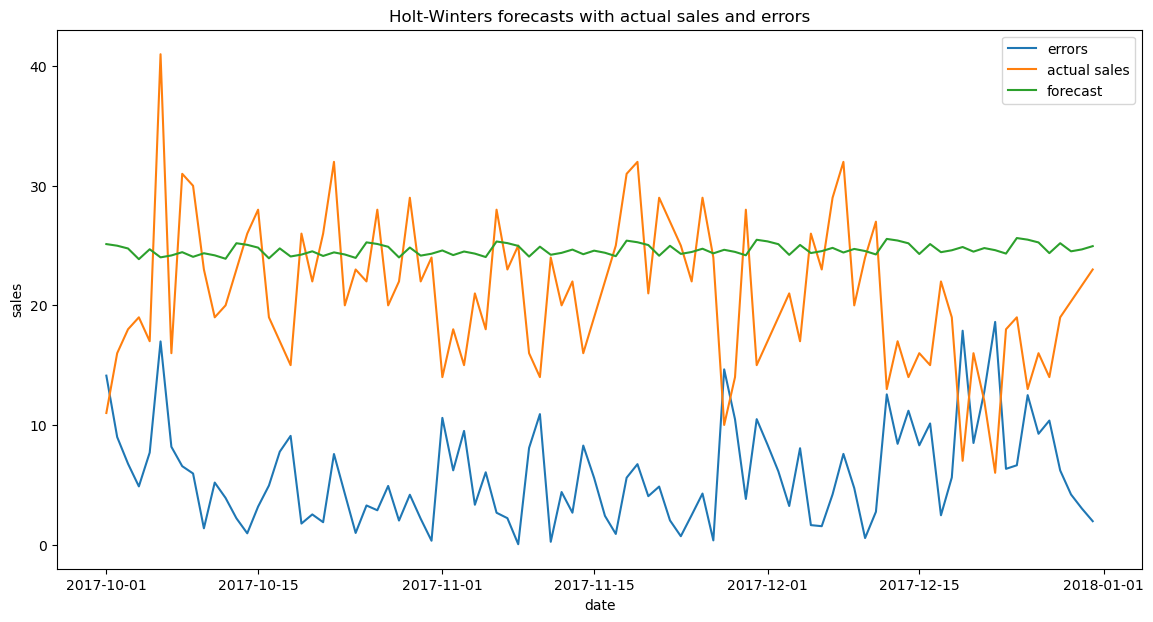

,total_sales,total_pred_sales,holt_winters_overall_error,MAE,RMSE,MAPE
model,,,,,,
Holt-Winters,1928.0,2266.176515,-338.176515,5.838367,7.145751,27.859428


In [29]:

errors_df_hw = pd.merge(test_df, pred_fit_1, left_on='date', right_on='index')
errors_df_hw = errors_df_hw[['date', 'sales', 'pred_sales']]
errors_df_hw['errors'] = errors_df_hw.sales - errors_df_hw.pred_sales
errors_df_hw.insert(0, 'model', 'Holt-Winters')



plt.figure(figsize=(14,7))
plt.plot(train_df['date'], train_df['sales'], label='Train')
plt.plot(test_df['date'], test_df['sales'], label='Test')
plt.plot(errors_df_hw['date'], errors_df_hw['pred_sales'], label='Forecast - HW no damping')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Holt-Winters without damping trend component')
plt.show()


plt.figure(figsize=(14,7))
plt.plot(errors_df_hw['date'], np.abs(errors_df_hw['errors']), label='errors')
plt.plot(errors_df_hw['date'], errors_df_hw['sales'], label='actual sales')
plt.plot(errors_df_hw['date'], errors_df_hw['pred_sales'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Holt-Winters forecasts with actual sales and errors')
plt.show()

result_df_hw = errors_df_hw.groupby('model').agg(total_sales=('sales', 'sum'),
                                          total_pred_sales=('pred_sales', 'sum'),
                                          holt_winters_overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse), 
                                          MAPE=('errors', mape))
result_df_hw

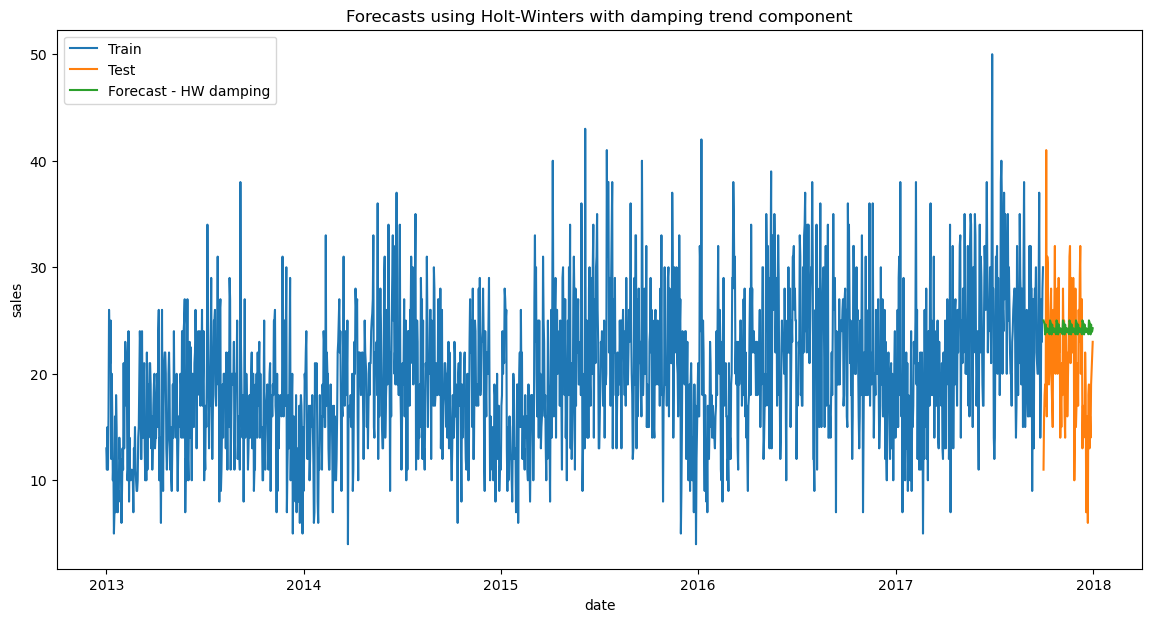

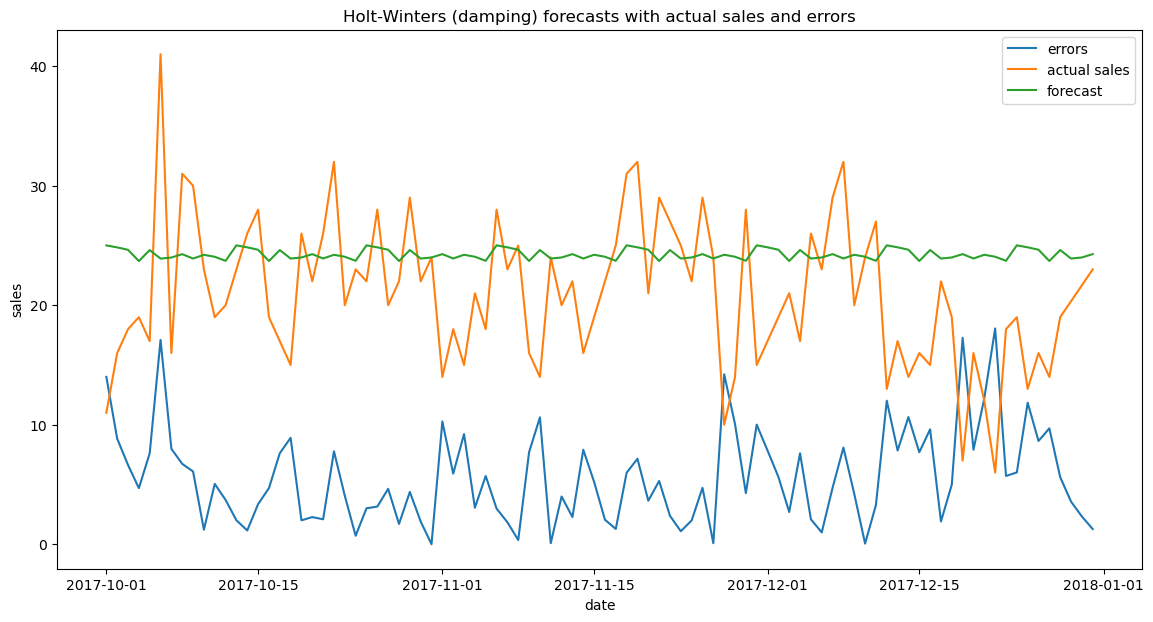

,total_sales,total_pred_sales,holt_winters_overall_error,MAE,RMSE,MAPE
model,,,,,,
Holt-Winters-Damped,1928.0,2231.234641,-303.234641,5.639174,6.923095,26.908921


In [30]:

errors_df_hwd = pd.merge(test_df, pred_fit_2, left_on='date', right_on='index')
errors_df_hwd = errors_df_hwd[['date', 'sales','pred_sales']]
errors_df_hwd['errors'] = errors_df_hwd.sales - errors_df_hwd.pred_sales
errors_df_hwd.insert(0, 'model', 'Holt-Winters-Damped') 


plt.figure(figsize=(14,7))
plt.plot(train_df['date'], train_df['sales'], label='Train')
plt.plot(test_df['date'], test_df['sales'], label='Test')
plt.plot(errors_df_hwd['date'], errors_df_hwd['pred_sales'], label='Forecast - HW damping')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Holt-Winters with damping trend component')
plt.show()

plt.figure(figsize=(14,7))
plt.plot(errors_df_hwd['date'], np.abs(errors_df_hwd['errors']), label='errors')
plt.plot(errors_df_hwd['date'], errors_df_hwd['sales'], label='actual sales')
plt.plot(errors_df_hwd['date'], errors_df_hwd['pred_sales'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Holt-Winters (damping) forecasts with actual sales and errors')
plt.show()

result_df_hwd = errors_df_hwd.groupby('model').agg(total_sales=('sales', 'sum'),
                                          total_pred_sales=('pred_sales', 'sum'),
                                          holt_winters_overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse), 
                                          MAPE=('errors', mape))
result_df_hwd

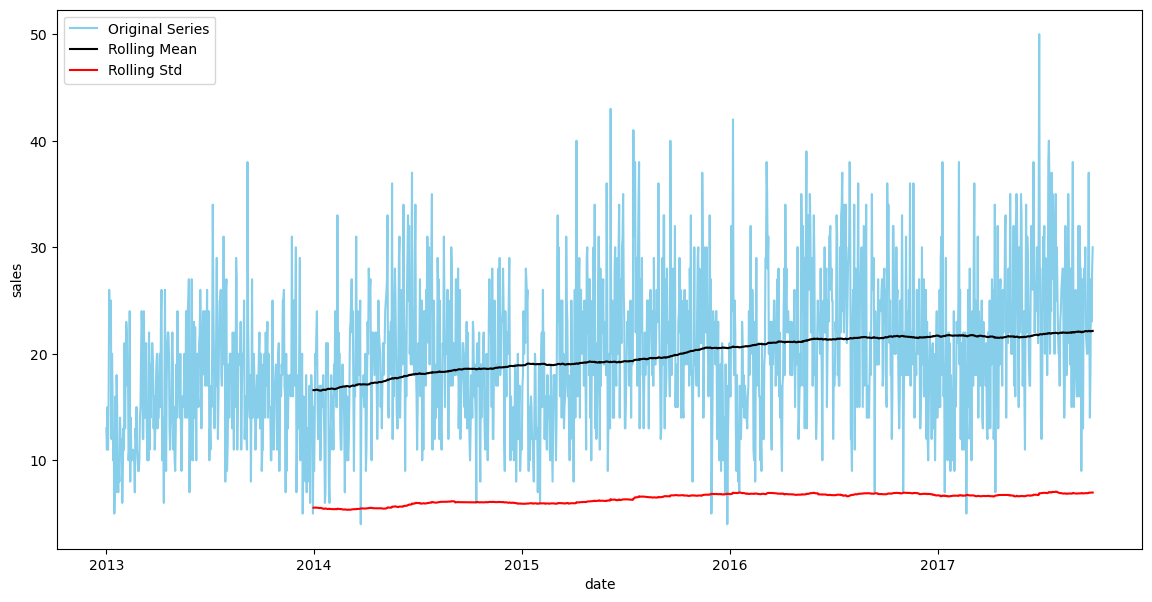

Test statistic = -4.640
P-value = 0.000
Critical values :
	1%: -3.434177666727206 - The data is  stationary with 99% confidence
	5%: -2.8632307003234203 - The data is  stationary with 95% confidence
	10%: -2.5676700828345895 - The data is  stationary with 90% confidence


In [31]:
arima_df = train_df[['date', 'sales']].set_index('date')
arima_test_df = test_df[['date', 'sales']].set_index('date')

def test_stationarity(timeseries):
    
    rollmean = timeseries.rolling(window=365).mean()
    rollstd = timeseries.rolling(window=365).std()

    plt.figure(figsize=(14,7))
    plt.plot(timeseries, color='skyblue', label='Original Series')
    plt.plot(rollmean, color='black', label='Rolling Mean')
    plt.plot(rollstd, color='red', label='Rolling Std')
    plt.legend(loc='best')
    plt.xlabel('date')
    plt.ylabel('sales')
    plt.show()
    
    
    adfuller_test = adfuller(timeseries, autolag='AIC')
    print("Test statistic = {:.3f}".format(adfuller_test[0]))
    print("P-value = {:.3f}".format(adfuller_test[1]))
    print("Critical values :")
    
    for key, value in adfuller_test[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence"
              .format(key, value, '' if adfuller_test[0] < value else 'not', 100-int(key[:-1])))
        

    fig, ax = plt.subplots(2, figsize=(14,7))
    ax[0] = plot_acf(timeseries, ax=ax[0], lags=20)
    ax[1] = plot_pacf(timeseries, ax=ax[1], lags=20)
    
test_stationarity(arima_df.sales)

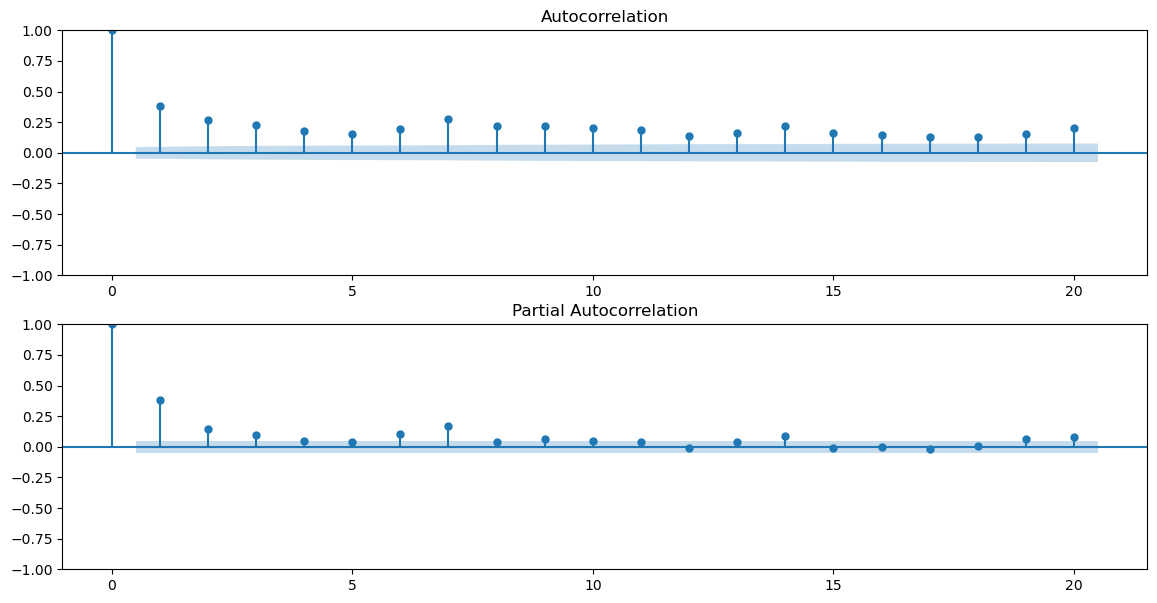

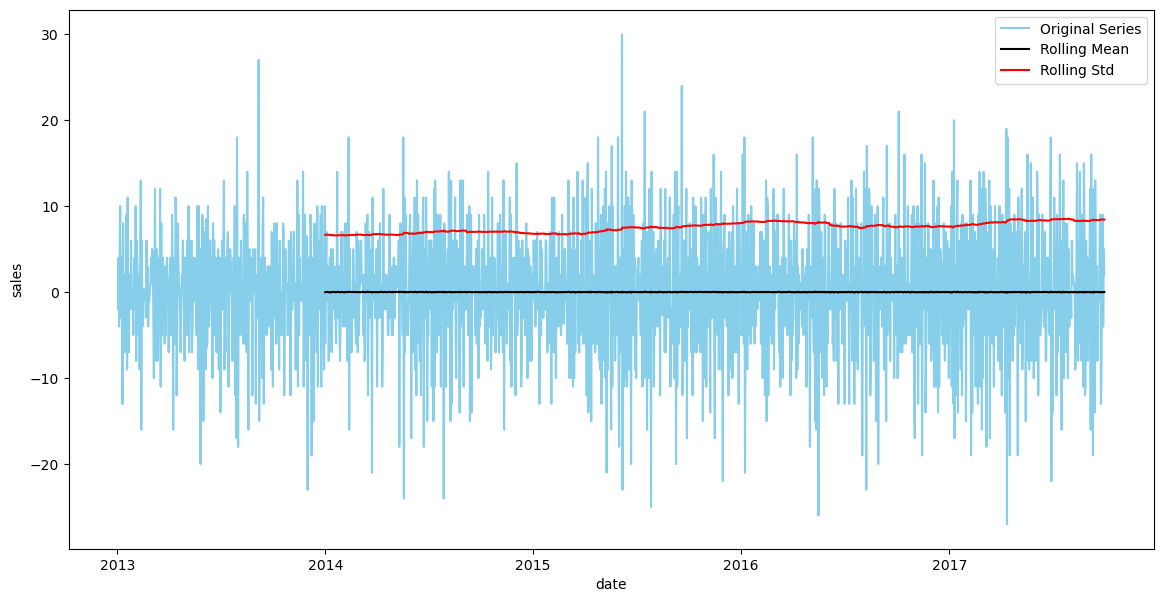

Test statistic = -13.661
P-value = 0.000
Critical values :
	1%: -3.4341866496114535 - The data is  stationary with 99% confidence
	5%: -2.8632346655630943 - The data is  stationary with 95% confidence
	10%: -2.567672194245481 - The data is  stationary with 90% confidence


In [32]:
first_difference = arima_df.sales - arima_df.sales.shift(1)
first_difference = pd.DataFrame(first_difference.dropna(inplace=False))

test_stationarity(first_difference.sales)

In [33]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(arima_df['sales'], order=(6, 1, 1))
arima_fit = arima_model.fit()

print(arima_fit.summary())

C:\TOOL\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\TOOL\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\TOOL\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1734
Model:                 ARIMA(6, 1, 1)   Log Likelihood               -5556.476
Date:                Mon, 16 Jun 2025   AIC                          11128.951
Time:                        23:52:03   BIC                          11172.612
Sample:                    01-01-2013   HQIC                         11145.099
                         - 09-30-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2058      0.025      8.125      0.000       0.156       0.255
ar.L2          0.0293      0.025      1.180      0.238      -0.019       0.078
ar.L3          0.0077      0.025      0.312      0.7

C:\TOOL\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\TOOL\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\TOOL\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


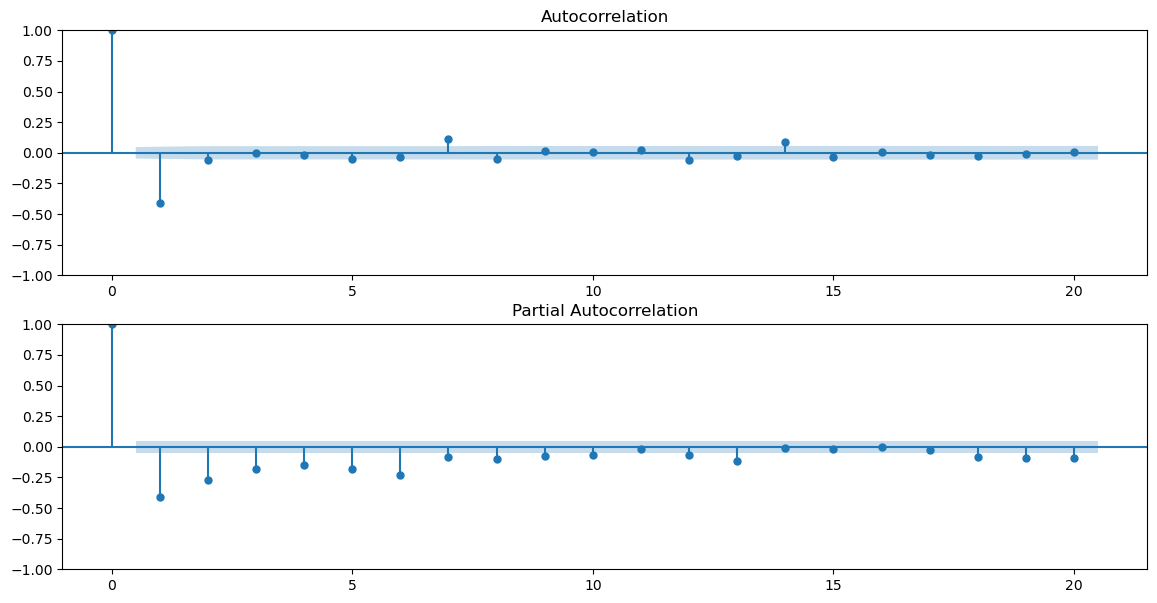

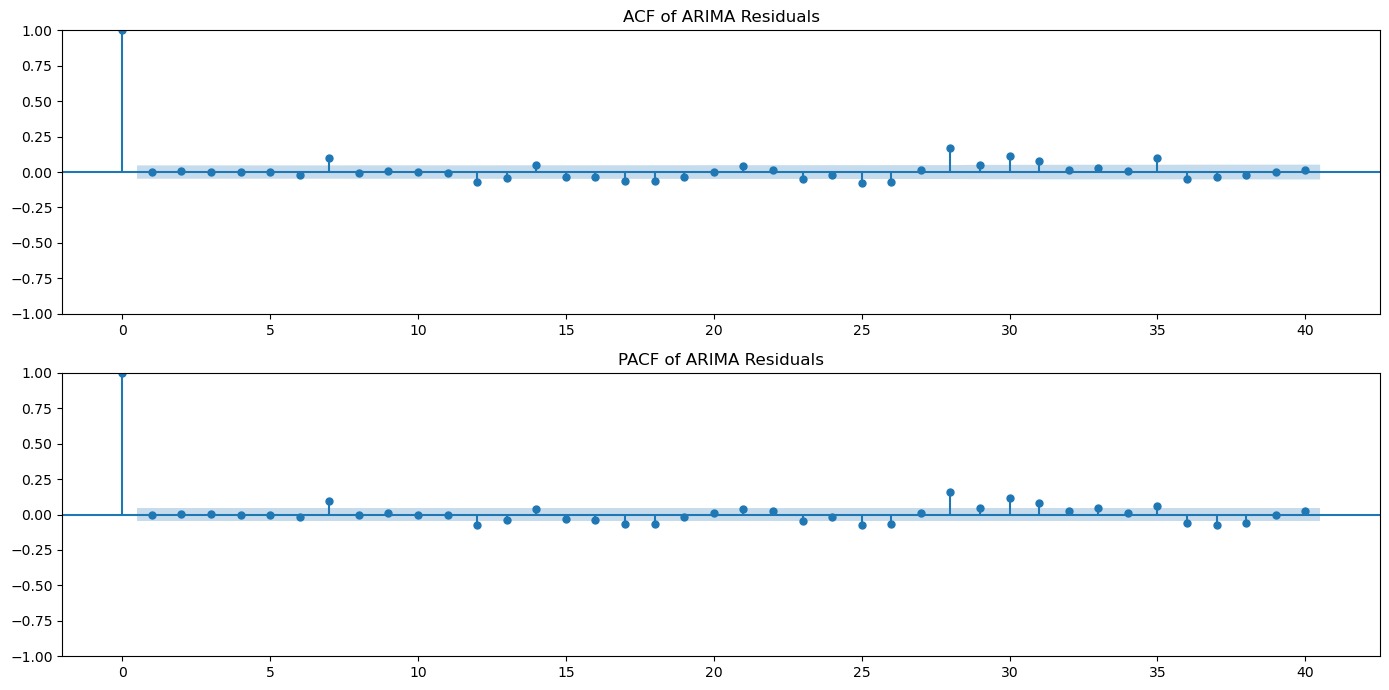

In [34]:
arima_model = ARIMA(arima_df['sales'], order=(6, 1, 1))
arima_fit = arima_model.fit()


residuals = arima_fit.resid


fig, ax = plt.subplots(2, figsize=(14, 7))
plot_acf(residuals, ax=ax[0], lags=40)
plot_pacf(residuals, ax=ax[1], lags=40)

ax[0].set_title("ACF of ARIMA Residuals")
ax[1].set_title("PACF of ARIMA Residuals")

plt.tight_layout()
plt.show()


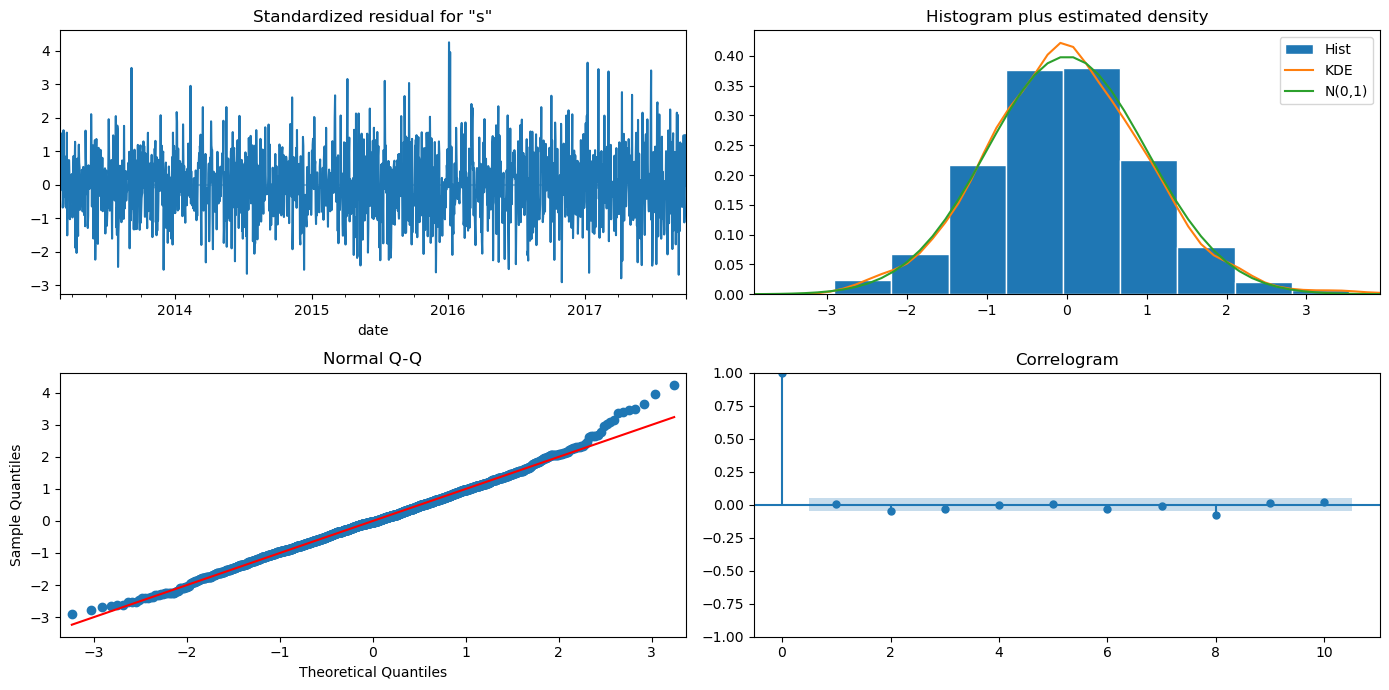

In [35]:
if 'date' not in arima_df.columns:
    arima_df = arima_df.reset_index()

arima_df['date'] = pd.to_datetime(arima_df['date'])
arima_df = arima_df.set_index('date').asfreq('D')

if 'date' not in arima_test_df.columns:
    arima_test_df = arima_test_df.reset_index()

arima_test_df['date'] = pd.to_datetime(arima_test_df['date'])
arima_test_df = arima_test_df.set_index('date').asfreq('D')


sarima_model = SARIMAX(arima_df['sales'],
                       order=(6, 1, 0),
                       seasonal_order=(6, 1, 0, 7),
                       enforce_invertibility=False,
                       enforce_stationarity=False)

sarima_fit = sarima_model.fit(disp=False)


forecast = sarima_fit.predict(start=arima_test_df.index[0],
                              end=arima_test_df.index[-1],
                              dynamic=True)


forecast = forecast.reindex(arima_test_df.index)

arima_test_df['pred_sales'] = forecast

sarima_fit.plot_diagnostics(figsize=(14, 7))
plt.tight_layout()
plt.show()

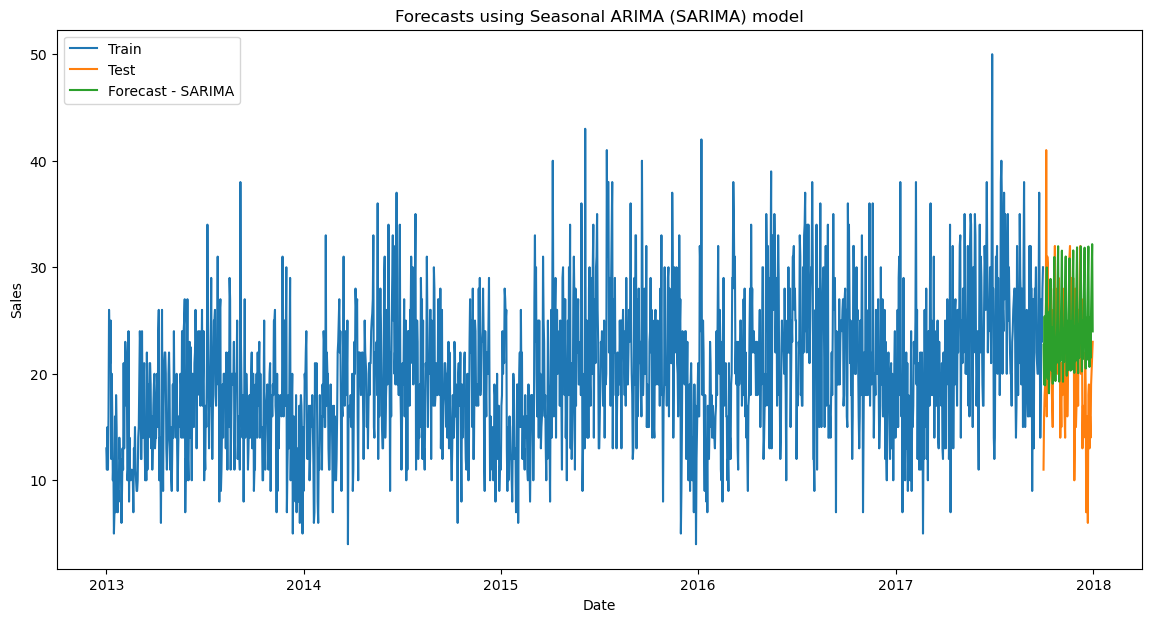

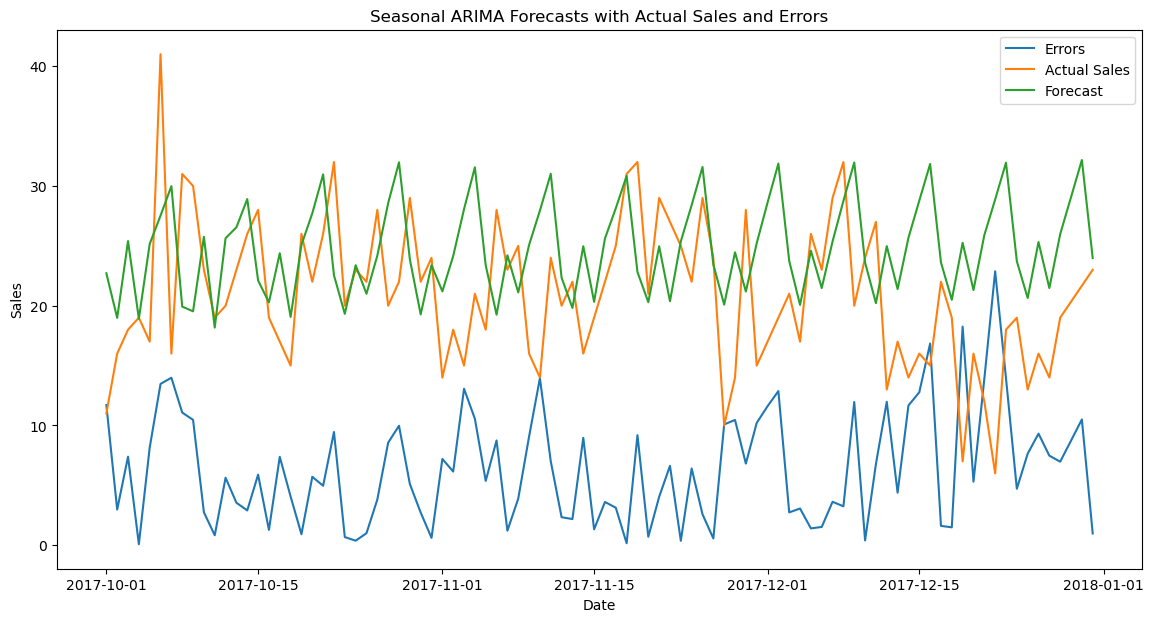

,total_sales,total_pred_sales,SARIMA_overall_error,MAE,RMSE,MAPE
model,,,,,,
SARIMA,1928.0,2270.0121,-342.0121,6.458554,8.02342,30.818827


In [36]:
arima_test_df['errors'] = arima_test_df.sales - arima_test_df.pred_sales
arima_test_df['model'] = 'SARIMA'  # Safer than insert


plt.figure(figsize=(14, 7))
plt.plot(train_df['date'], train_df['sales'], label='Train')
plt.plot(arima_test_df.index, arima_test_df['sales'], label='Test')
plt.plot(arima_test_df.index, arima_test_df['pred_sales'], label='Forecast - SARIMA')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Forecasts using Seasonal ARIMA (SARIMA) model')
plt.show()


plt.figure(figsize=(14, 7))
plt.plot(arima_test_df.index, np.abs(arima_test_df['errors']), label='Errors')
plt.plot(arima_test_df.index, arima_test_df['sales'], label='Actual Sales')
plt.plot(arima_test_df.index, arima_test_df['pred_sales'], label='Forecast')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Seasonal ARIMA Forecasts with Actual Sales and Errors')
plt.show()


result_df_sarima = arima_test_df.groupby('model').agg(
    total_sales=('sales', 'sum'),
    total_pred_sales=('pred_sales', 'sum'),
    SARIMA_overall_error=('errors', 'sum'),
    MAE=('errors', mae),
    RMSE=('errors', rmse),
    MAPE=('errors', mape)
)

result_df_sarima


In [37]:
reg_df = df
reg_df

,date,store,item,sales,year,month,day,weekday
0,2013-01-01,1,1,13.000000,2013,1,1,1
31,2013-01-02,1,1,11.000000,2013,1,2,2
59,2013-01-03,1,1,15.000000,2013,1,3,3
90,2013-01-04,1,1,11.000000,2013,1,4,4
120,2013-01-05,1,1,16.000000,2013,1,5,5
...,...,...,...,...,...,...,...,...
1821,2017-12-27,1,1,14.000000,2017,12,27,2
1822,2017-12-28,1,1,19.000000,2017,12,28,3
1823,2017-12-29,1,1,20.333333,2017,12,29,4
1824,2017-12-30,1,1,21.666667,2017,12,30,5


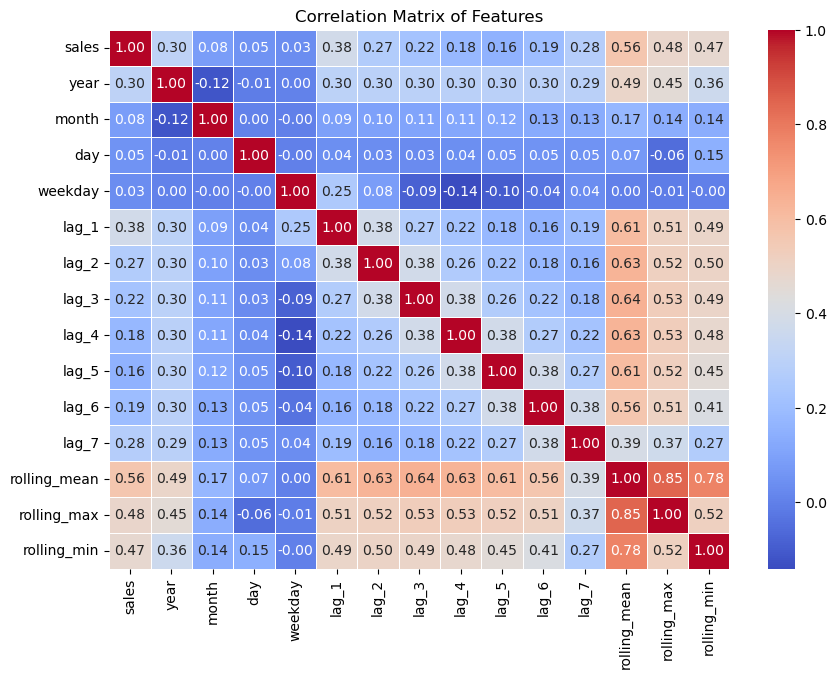

In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


if 'date' not in reg_df.columns and reg_df.index.name == 'date':
    reg_df = reg_df.reset_index()


for i in range(1, 8):
    reg_df[f'lag_{i}'] = reg_df['sales'].shift(i)


reg_df['rolling_mean'] = reg_df['sales'].rolling(window=7).mean()
reg_df['rolling_max'] = reg_df['sales'].rolling(window=7).max()
reg_df['rolling_min'] = reg_df['sales'].rolling(window=7).min()


reg_df = reg_df.dropna(how='any')


reg_df = reg_df.drop(['store', 'item'], axis=1, errors='ignore')


reg_df['date'] = pd.to_datetime(reg_df['date'])  # ensure datetime
reg_df = reg_df.set_index('date')


reg_train_df = reg_df.loc[:'2017-09-30']
reg_test_df = reg_df.loc['2017-10-01':]

corr = reg_train_df.corr()
plt.figure(figsize=(10, 7))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of Features")
plt.show()


In [39]:
X_train = reg_train_df.drop(['sales'], axis=1)
y_train = reg_train_df['sales'].values

X_test = reg_test_df.drop(['sales'], axis=1)
y_test = reg_test_df['sales'].values


top_features = SelectKBest(score_func=f_regression, k=5)
fit = top_features.fit(X_train, y_train)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X_train.columns)


feature_scores = pd.concat([df_columns, df_scores], axis=1)
feature_scores.columns = ['Feature','Score']
print(feature_scores.nlargest(5,'Score')) 

         Feature       Score
11  rolling_mean  806.317368
12   rolling_max  526.787930
13   rolling_min  499.227690
4          lag_1  289.244557
0           year  176.597169


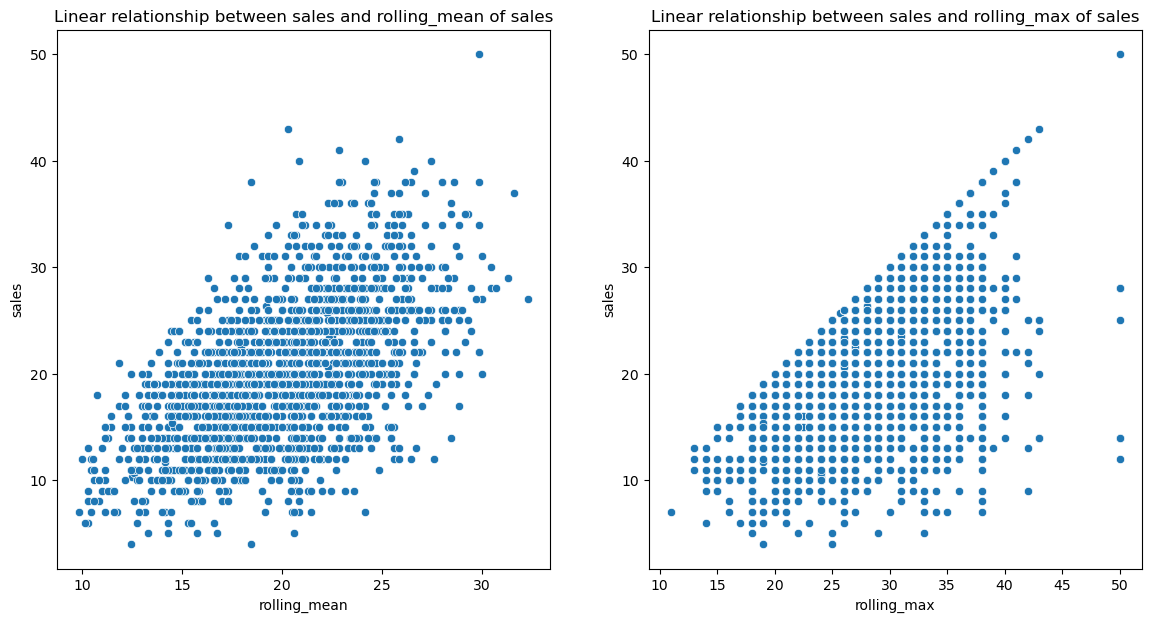

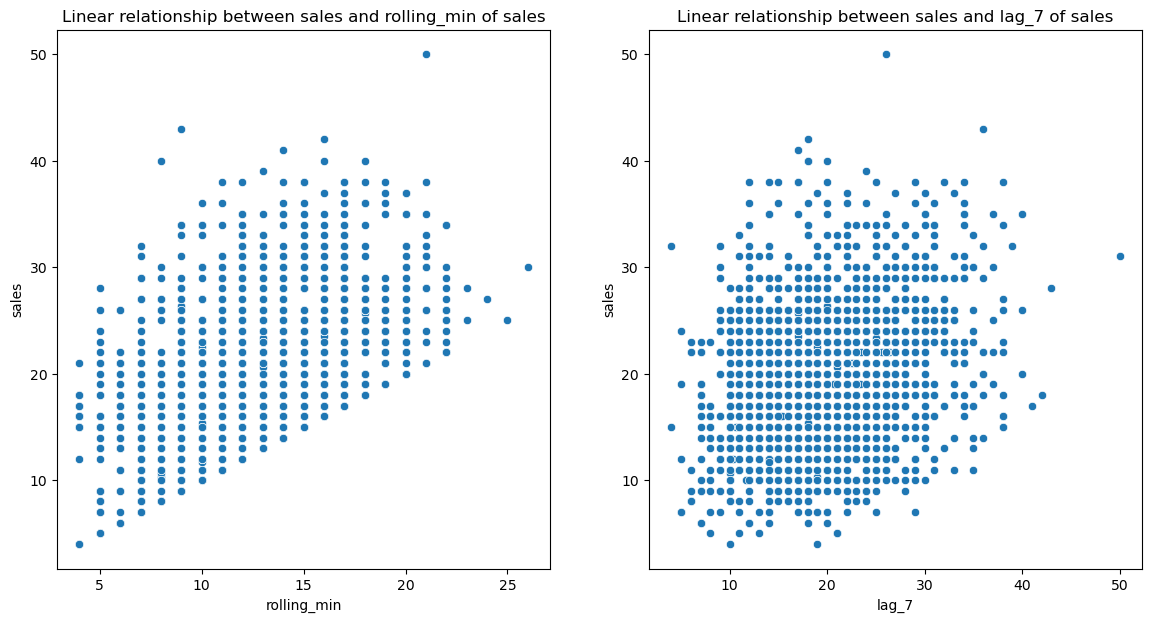

In [40]:
fig, axs = plt.subplots(ncols=2, figsize=(14,7))
sns.scatterplot(x=reg_train_df['rolling_mean'], y=reg_train_df['sales'], ax=axs[0])
axs[0].set(title='Linear relationship between sales and rolling_mean of sales')
sns.scatterplot(x=reg_train_df['rolling_max'], y=reg_train_df['sales'], ax=axs[1])
axs[1].set(title='Linear relationship between sales and rolling_max of sales')

fig, axs = plt.subplots(ncols=2, figsize=(14,7))
sns.scatterplot(x=reg_train_df['rolling_min'], y=reg_train_df['sales'], ax=axs[0])
axs[0].set(title='Linear relationship between sales and rolling_min of sales')
sns.scatterplot(x=reg_train_df['lag_7'], y=reg_train_df['sales'], ax=axs[1])
axs[1].set(title='Linear relationship between sales and lag_7 of sales')

plt.show()

In [41]:

X_train = X_train[['rolling_mean', 'rolling_max', 'rolling_min', 'lag_7', 'lag_1']]
X_test = X_test[['rolling_mean', 'rolling_max', 'rolling_min', 'lag_7', 'lag_1']]


model = LinearRegression()
model.fit(X_train, y_train)

preds = model.predict(X_test)

errors_df = reg_test_df[['sales']]
errors_df['pred_sales'] = preds
errors_df['errors'] = preds - y_test
errors_df.insert(0, 'model', 'LinearRegression')

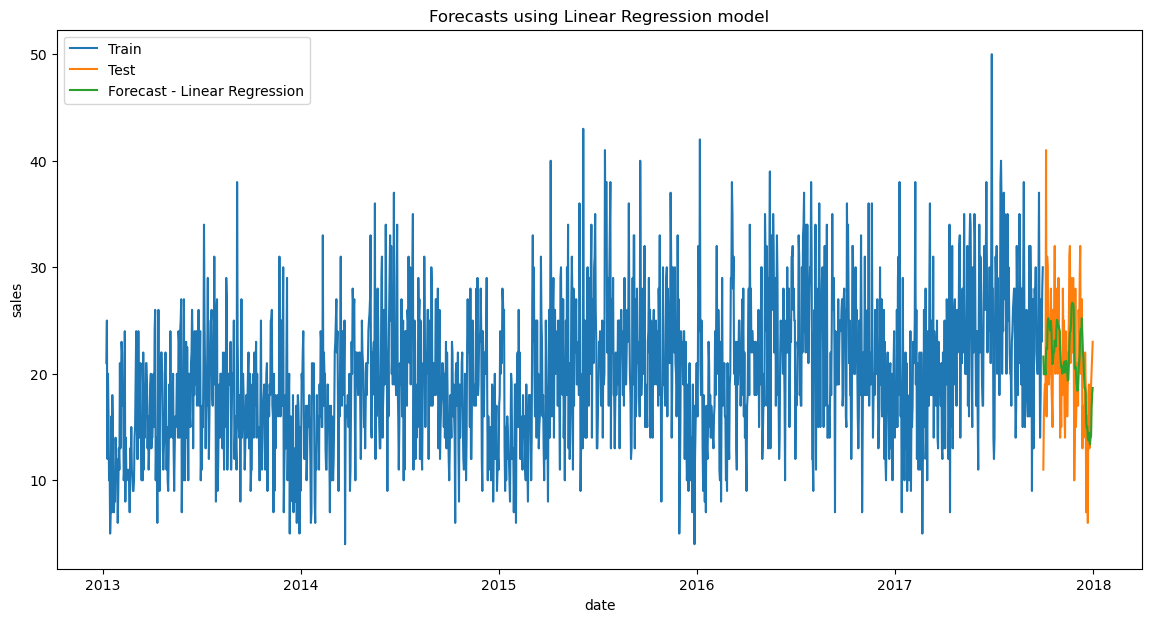

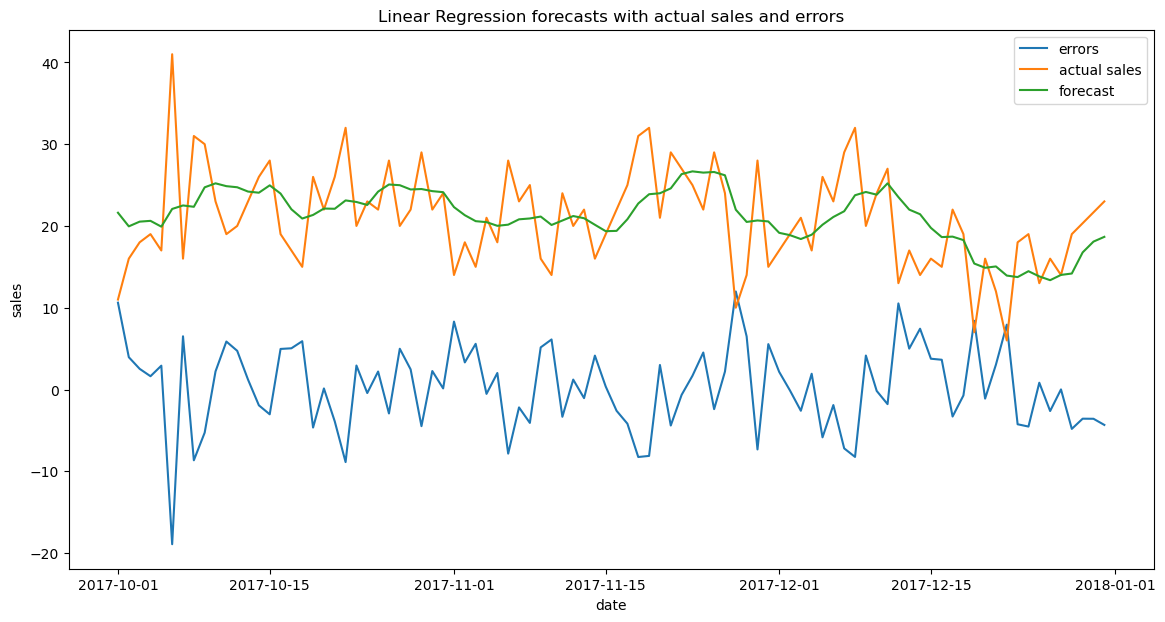

,total_sales,total_pred_sales,LR_overall_error,MAE,RMSE,MAPE
model,,,,,,
LinearRegression,1928.0,1950.771256,22.771256,4.178834,5.181288,19.940495


In [42]:

fig = plt.figure(figsize=(14,7))
plt.plot(reg_train_df.index, reg_train_df['sales'], label='Train')
plt.plot(reg_test_df.index, reg_test_df['sales'], label='Test')
plt.plot(errors_df.index, errors_df['pred_sales'], label='Forecast - Linear Regression')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Linear Regression model')
plt.show()

fig = plt.figure(figsize=(14,7))
plt.plot(errors_df.index, errors_df.errors, label='errors')
plt.plot(errors_df.index, errors_df.sales, label='actual sales')
plt.plot(errors_df.index, errors_df.pred_sales, label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Linear Regression forecasts with actual sales and errors')
plt.show()

import numpy as np
result_df_lr = errors_df.groupby('model').agg(total_sales=('sales', 'sum'),
                                          total_pred_sales=('pred_sales', 'sum'),
                                          LR_overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse), 
                                          MAPE=('errors', mape))
result_df_lr

### Gmail: gowthamgspatilproject@gmail.com
### Linkedin: https://www.linkedin.com/in/gowthamgshivamuthy
### Github: https://github.com/gowthamgspatil